In [36]:
# Import modules
import numpy as np
import pandas as pd
import struct
import gzip
import tensorflow as tf
from matplotlib import pyplot as plt

## Read train data

In [63]:
# Train images
with gzip.open('zipped/train-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    train_X = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_X = train_X.reshape((size, nrows, ncols))

# Train labels
with open('unzipped/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_y = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_y = train_y.reshape((size,)) # (Optional)

## Read test data

In [62]:
# Test images
with gzip.open('zipped/t10k-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    test_X = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_X = test_X.reshape((size, nrows, ncols))
    
# Train labels
with open('unzipped/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_y = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_y = test_y.reshape((size,)) # (Optional)

## View some stats about the data

In [64]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test: ' + str(test_X.shape))
print('Y_test: ' + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


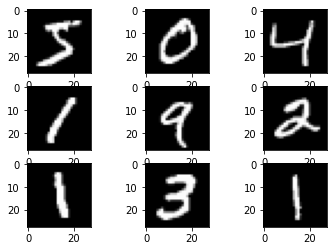

In [67]:
# Plot the first 9 numbers of the train set
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap='gray')
plt.show()

# Split into 3 local section

- One for digits 0-2
- One for digits 3-5
- One for digits 5-9

In [71]:
train_X_group_one = []
train_y_group_one = []

for n in range(len(train_X)):
  if 0 <= train_y[n] <= 2:
    train_X_group_one.append(train_X[n])
    train_y_group_one.append(train_y[n])

train_X_group_two = []
train_y_group_two = []

for n in range(len(train_X)):
  if 3 <= train_y[n] <= 5:
    train_X_group_two.append(train_X[n])
    train_y_group_two.append(train_y[n])

train_X_group_three = []
train_y_group_three = []

for n in range(len(train_X)):
  if 6 <= train_y[n] <= 9:
    train_X_group_three.append(train_X[n])
    train_y_group_three.append(train_y[n])

## Verify grouping was succesfull

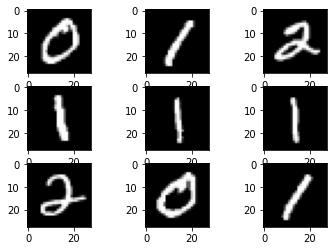

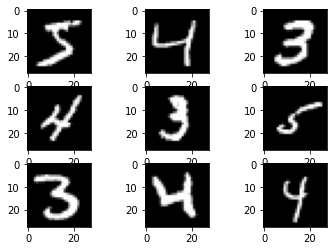

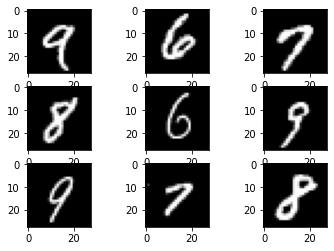

In [72]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X_group_one[i], cmap='gray')
plt.show()

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X_group_two[i], cmap='gray')
plt.show()

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X_group_three[i], cmap='gray')
plt.show()